<a href="https://colab.research.google.com/github/zixian0821-zoe/financial-computing-workshop/blob/main/Copy_of_EN_533_744_Lecture_5_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The goal of this notebook is to learn how to:**

1) Install and use PyTorch

2) Represent graphs and graph signals as PyTorch tensors

3) Define PyTorch model: simple perceptron

4) Implement a simple training, validation, and testing loop

In [ ]:
#@title Standard libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import random


In [ ]:
# Installing PyTorch

!pip3 install torch torchvision torchaudio
import torch
import torch.nn as nn
import torch.optim as optim

We will work on a source localization problem on an undirected **Erdos-Renyi graph**. The adjacency matrix of an Erdos-Renyi graph with parameter $p$ is defined as:
$$
[A]_{ij} \sim \text{Bernoulli}(p)
$$

i.e., given nodes $i$ and $j$, edge $(i,j)$ is sampled with probability $p$.

**Let's write a function to generate this graph in NumPy:**


In [ ]:
def generate_ER_graph(n, p):

  A = np.random.binomial(1, p, size = (n,n)) # Bernoulli(p) is Binomial(1, p)

  for i in range(n):
    A[i,i] = 0 # Removing self-loops

  return A


**Next let's test this function and visualize the graph using NetworkX.**


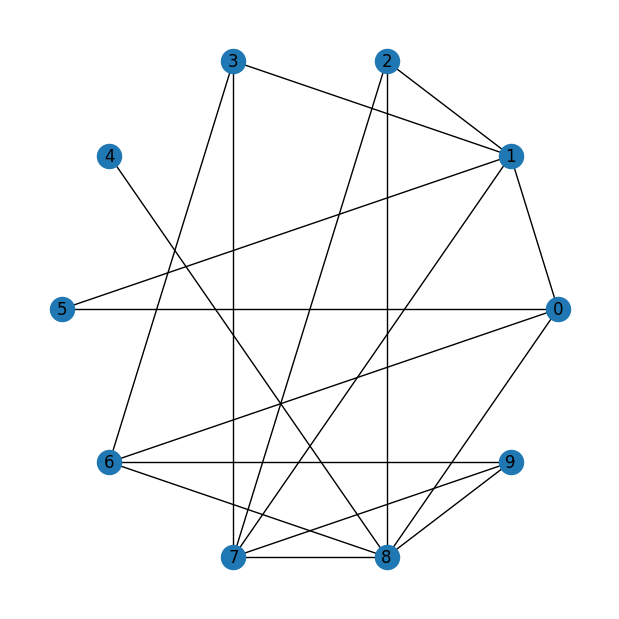

In [ ]:
n = 10
p = 0.2

A = generate_ER_graph(n, p)

G = nx.from_numpy_array(A) # Creating NetworkX graph object

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, pos=nx.circular_layout(G)) # Drawing the graph with circular layout

In order to represent high-dimensional data and allow for GPU training, PyTorch uses its own data type---PyTorch tensors. While we can always convert NumPy arrays to PyTorch tensors (and vice-versa), the PyTorch library has a syntax that is very close to NumPy so, when convenient, we will prefer to write our data in PyTorch directly.

In [ ]:
A_tensor = torch.from_numpy(A) # Converting from NumPy, option 1...

def generate_tensor_ER_graph(n, p): # ... modifying function to output a tensor, option 2

  A = np.random.binomial(1, p, size = (n,n)) # Bernoulli(p) is Binomial(1, p)

  for i in range(n):
    A[i,i] = 0 # Removing self-loops

  return torch.from_numpy(A)

A_tensor = generate_tensor_ER_graph(n, p)

Now, let's generate the graph signals for this problem. The source localization task is as follows. Suppose we observe a snapshot of a graph diffusion process originating from an unknown seed node $i$ at time $t$; predict the seed $i$.

**First we write a function to generate $N$ diffusion processes with random seed and horizon $T$:**

In [ ]:
#@title Aux

def print_graph_signal(G,x,ax):

  x = x.numpy()
  for i, node in enumerate(G.nodes):
    G.nodes[node]['value'] = x[i]

  # Get the node values
  node_values = [G.nodes[node]['value'] for node in G.nodes]

  # Normalize the node values (if you need to)
  norm = plt.Normalize(min(node_values), max(node_values))

  # Choose a colormap (e.g., 'viridis', 'plasma', etc.)
  cmap = plt.cm.magma

  # Get the node color mapping
  node_colors = [cmap(norm(value)) for value in node_values]

  # Draw the graph with node colors
  nx.draw(G, ax=ax, with_labels=True, node_color=node_colors, pos=nx.circular_layout(G))


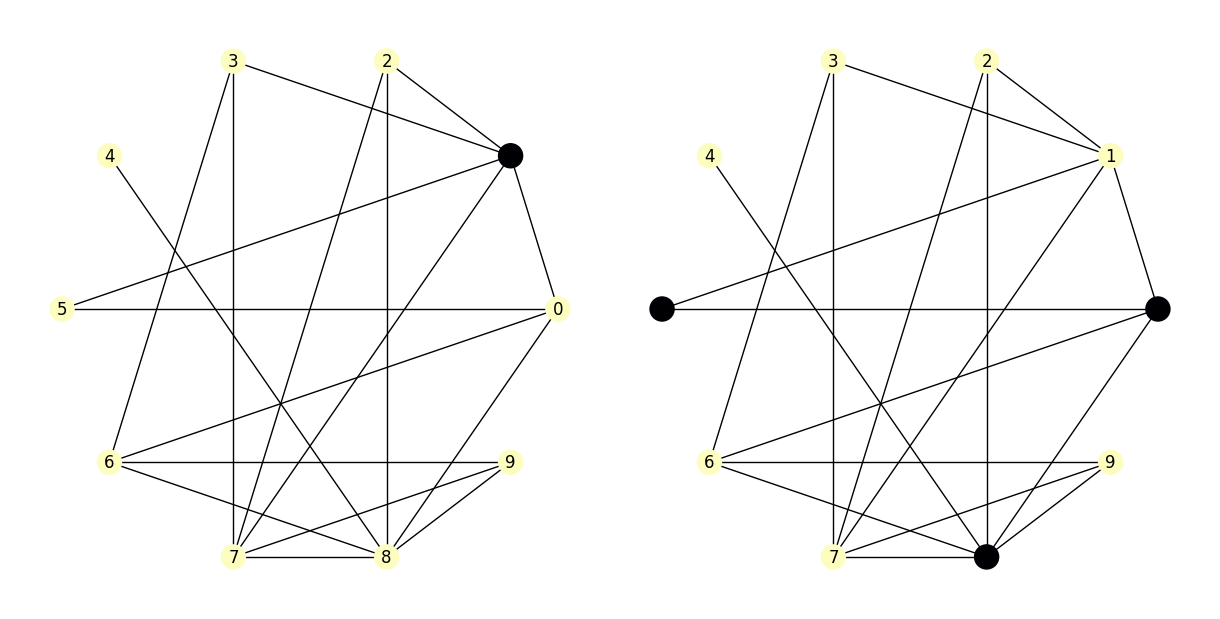

In [ ]:
def generate_diffusions(A, T, N):

  n = A.shape[0] # number of nodes

  seeds = torch.randint(0,n,(N,)) # generates N random seeds between 0 and n
  one_hot_seeds = torch.nn.functional.one_hot(seeds,num_classes=n)

  initial_signals = torch.matmul(torch.diag(torch.randn(N)),one_hot_seeds.float()) # generates N input signals with x ~ N(0,1) at the seed and 0 everywhere else

  diffusion = torch.unsqueeze(initial_signals,dim=2) # transforms a N x n tensor into a N x n x 1 tensor
  current_signals = initial_signals # keeps track of the current diffused signal
  for t in range(T):
    current_signals = torch.matmul(current_signals,A.float()) # one-step diffusion
    diffusion = torch.cat((diffusion,current_signals.unsqueeze(2)),dim=2) # concatenation along dim=2

  return one_hot_seeds, diffusion

# Testing the function
_ , x = generate_diffusions(A_tensor, 3, 1)

# Create a single figure
fig = plt.figure(figsize=(12, 6))

# Create axes manually (define positions for each plot)
ax1 = fig.add_axes([0, 0, 0.5, 1])  # Position for the first plot (left half)
ax2 = fig.add_axes([0.5, 0, 0.5, 1])  # Position for the second plot (right half)

x0 = x[0,:,0] # initial signal
print_graph_signal(G,x0,ax1)
xT = x[0,:,-1] # final signal
print_graph_signal(G,xT,ax2)


Now that we have our diffusion process, we can generate the input and output graph signals. For each sample, the *input signal (predictor) should be the snapshot at random time step $t$*; and the *output signal (observation) should be the one-hot representation of the seed*.

**Let's write a function that uses the above function generate_diffusions to construct the dataset.**

In [ ]:
def generate_data(A, T, N):

  y , diffusion = generate_diffusions(A_tensor, T, N)

  x = torch.zeros(N,n)
  for i in range(N):
    rand_t = np.random.randint(0,T)
    x[i,:] = diffusion[i,:,rand_t]

  return x, y

# Generating the data
N = 10000
T = 8
x, y = generate_data(A_tensor, T, N)

# Checking shapes
print(x.shape)
print(y.shape)

torch.Size([10000, 10])
torch.Size([10000, 10])


Onto the machine learning model. We will first create a **class implementing the linear map of an FCNN**. Then we will create a **class implementing a one-layer FCNN (perceptron)**.

In [ ]:
# The linear layer is the linear operation in the FCNN layer

class LinearLayer(torch.nn.Module):

  # Parameter initialization: important to prevent vanishing/exploding gradients
  # Here we use a simple uniform initialization
  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.d_in)
    self.weight.data.uniform_(-stdv, stdv)
    self.bias.data.uniform_(-stdv, stdv)

  # Object instantiation
  def __init__(self, d_in, d_out):
    super().__init__()

    self.d_in = d_in
    self.d_out = d_out

    # Defining the learnable parameters
    self.weight = torch.nn.parameter.Parameter(torch.Tensor(d_in,d_out))
    self.bias = torch.nn.parameter.Parameter(torch.Tensor(d_out,))

    # Initialize parameters
    self.reset_parameters()

  # Execution method
  def forward(self, x):
    y = torch.matmul(x, self.weight) + self.bias
    return y

# Using LinearLayer, we can now define our FCNN:

class FullyConnectedNN(torch.nn.Module):

  def __init__(self, d_in, d_out, nonlinearity = torch.nn.LogSoftmax(dim=-1)):
    super().__init__()

    self.d_in = d_in
    self.d_out = d_out
    self.nonlinearity = nonlinearity

    # Instead of applying one operation at a time, PyTorch allows us to define a
    # stack (composition) of operators
    self.fcnn_stack = torch.nn.Sequential(LinearLayer(d_in,d_out),
                                          nonlinearity,
                                          )
  def forward(self, x):
    return self.fcnn_stack(x)

# Testing a forward pass

fcnn = FullyConnectedNN(n,n)
example_y = fcnn(x)
print(example_y.shape)

torch.Size([10000, 10])


Obs.: Check the torch.nn.Linear() module from PyTorch. It's the PyTorch implementation of a linear layer, which serves the same purpose of our LinearLayer class above. Here, we write our own linear layer for didactic purposes. When applicable, you're welcome to use the PyTorch implementation in your assignments.

Next we'll write a function implementing a simple training loop for our model.

In [ ]:
def train_and_validate(model, inputs, targets, criterion = torch.nn.NLLLoss(), batch_size=100, lr=0.001, num_epochs=200, val_split=0.2, val_interval=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []


    # Shuffle and split dataset into training and validation sets
    indices = list(range(len(inputs)))
    random.shuffle(indices)
    split = int(len(inputs) * val_split)
    train_indices, val_indices = indices[split:], indices[:split]

    train_inputs, train_targets = [inputs[i] for i in train_indices], [targets[i] for i in train_indices]
    val_inputs, val_targets = [inputs[i] for i in val_indices], [targets[i] for i in val_indices]

    # Start training, train f over num_epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        step = 0

        for i in range(0, len(train_indices), batch_size):
            # Select current batch
            batch_inputs = torch.stack(train_inputs[i:i+batch_size])
            batch_targets = torch.stack(train_targets[i:i+batch_size])

            # Reset optimizer's gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(batch_inputs)
            # Loss computation
            loss = criterion(outputs, batch_targets.argmax(dim=1))
            # Backpropagation to compute gradients
            loss.backward()
            # Optimization step
            optimizer.step()

            running_loss += loss.item()
            step += 1

            # Perform validation at specified intervals
            if step % val_interval == 0:
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for j in range(0, len(val_indices), batch_size):
                        batch_val_inputs = torch.stack(val_inputs[j:j+batch_size])
                        batch_val_targets = torch.stack(val_targets[j:j+batch_size])

                        outputs = model(batch_val_inputs)
                        loss = criterion(outputs, batch_val_targets.argmax(dim=1))
                        val_loss += loss.item()

                avg_val_loss = val_loss / (len(val_indices) // batch_size)
                val_losses.append(avg_val_loss)
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step}], Train Loss: {running_loss/step:.4f}, Val Loss: {avg_val_loss:.4f}")

        avg_train_loss = running_loss / (len(train_indices) // batch_size)
        train_losses.append(avg_train_loss)

    return train_losses, val_losses


Finally, we train!

In [ ]:
# Let's first split the training + validation and test sets
test_split = 0.1

# Creating lists of inputs and outputs
inputs = [x[i] for i in range(x.shape[0])]
outputs = [y[i] for i in range(y.shape[0])]

indices = list(range(len(inputs)))
random.shuffle(indices)
split = int(len(inputs) * test_split)
train_indices, test_indices = indices[split:], indices[:split]

train_inputs, train_targets = [inputs[i] for i in train_indices], [outputs[i] for i in train_indices]
test_inputs, test_targets = [inputs[i] for i in test_indices], [outputs[i] for i in test_indices]

# Now we're ready to train
criterion = torch.nn.NLLLoss() # Like the cross entropy loss, but used when log softmax is used (more stable)
batch_size = 100
lr = 0.001 # learning rate
num_epochs = 50 # passes over the whole dataset
val_split = 0.2 # what % of the training samples to use for validation
val_interval = 10 # how often to validate the model
fcnn = FullyConnectedNN(n,n)
train_losses, val_losses = train_and_validate(fcnn,train_inputs,train_targets,
                                              criterion, batch_size,
                                              lr, num_epochs, val_split, val_interval)

Epoch [1/50], Step [10], Train Loss: 2.3325, Val Loss: 2.3319
Epoch [1/50], Step [20], Train Loss: 2.3266, Val Loss: 2.3306
Epoch [1/50], Step [30], Train Loss: 2.3246, Val Loss: 2.3294
Epoch [1/50], Step [40], Train Loss: 2.3254, Val Loss: 2.3283
Epoch [1/50], Step [50], Train Loss: 2.3268, Val Loss: 2.3272
Epoch [1/50], Step [60], Train Loss: 2.3277, Val Loss: 2.3260
Epoch [1/50], Step [70], Train Loss: 2.3265, Val Loss: 2.3249
Epoch [2/50], Step [10], Train Loss: 2.3230, Val Loss: 2.3237
Epoch [2/50], Step [20], Train Loss: 2.3180, Val Loss: 2.3229
Epoch [2/50], Step [30], Train Loss: 2.3165, Val Loss: 2.3222
Epoch [2/50], Step [40], Train Loss: 2.3170, Val Loss: 2.3215
Epoch [2/50], Step [50], Train Loss: 2.3186, Val Loss: 2.3207
Epoch [2/50], Step [60], Train Loss: 2.3195, Val Loss: 2.3199
Epoch [2/50], Step [70], Train Loss: 2.3185, Val Loss: 2.3191
Epoch [3/50], Step [10], Train Loss: 2.3168, Val Loss: 2.3183
Epoch [3/50], Step [20], Train Loss: 2.3124, Val Loss: 2.3178
Epoch [3

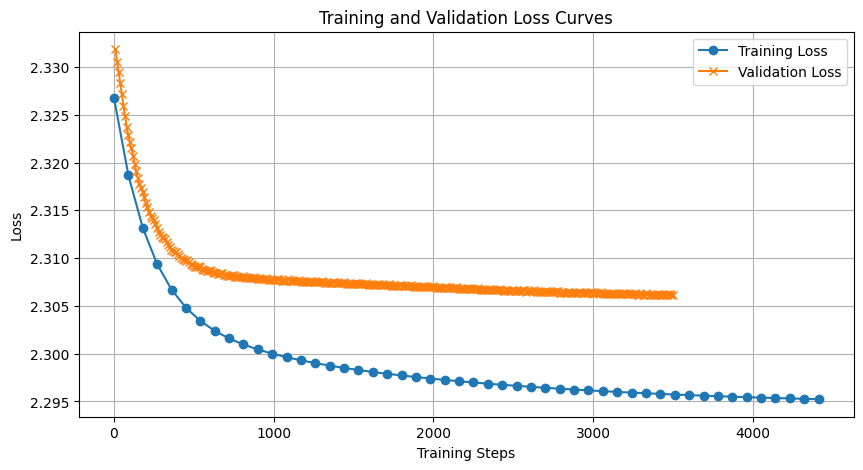

In [ ]:
def plot_loss_curves(train_losses, val_losses, val_interval, num_epochs, steps_per_epoch):
    plt.figure(figsize=(10, 5))

    # Compute x-axis values for training and validation loss
    train_steps = list(range(1, num_epochs * steps_per_epoch + 1, steps_per_epoch))
    val_steps = list(range(val_interval, val_interval * len(val_losses) + 1, val_interval))

    plt.plot(train_steps[:len(train_losses)], train_losses, label='Training Loss', marker='o')
    plt.plot(val_steps, val_losses, label='Validation Loss', marker='x')

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()


steps_per_epoch = len(train_inputs) // batch_size
plot_loss_curves(train_losses, val_losses, val_interval, num_epochs, steps_per_epoch)


Next, let's test our model by computing its accuracy on the test set.

In [ ]:
def test(model, inputs, targets):

    model.eval()
    with torch.no_grad():
      tensor_test_inputs = torch.stack(test_inputs)
      tensor_test_targets = torch.stack(test_targets)

      outputs = model(tensor_test_inputs)
      total = tensor_test_targets.shape[0]
      correct = (outputs.argmax(dim=1) == tensor_test_targets.argmax(dim=1)).sum().item()
      accuracy = 100 * correct / total

    return accuracy, outputs

test_accuracy, test_predictions = test(fcnn, test_inputs, test_targets)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 19.10%


Finally, let's compare some predictions to some targets.

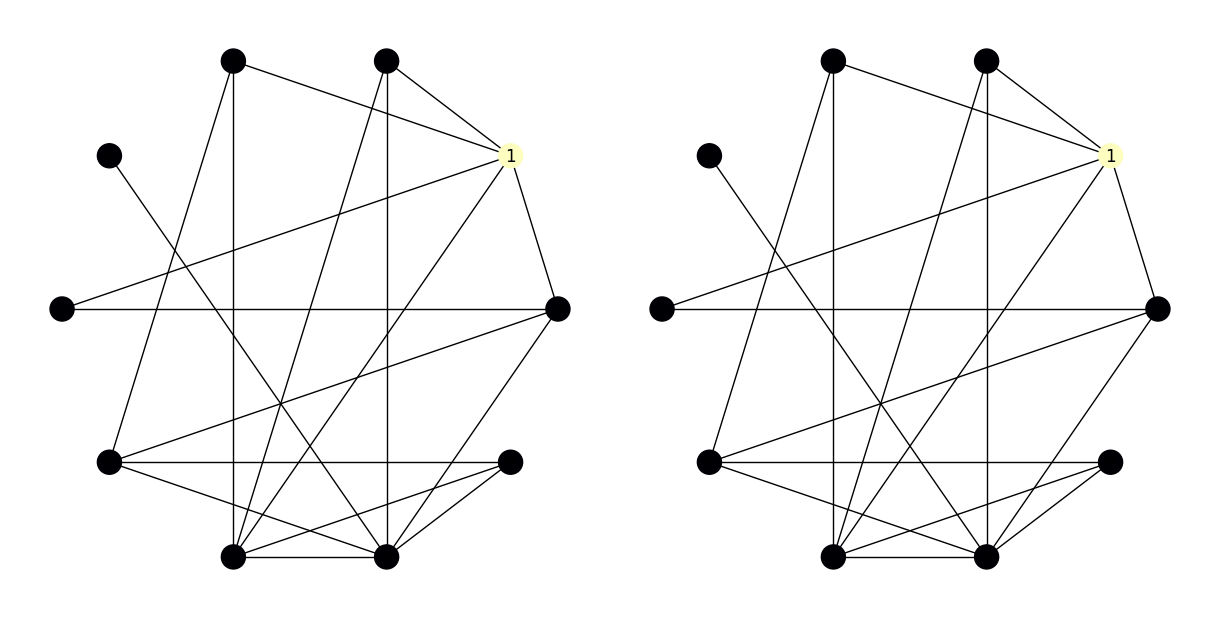

In [ ]:
# Create a single figure
fig = plt.figure(figsize=(12, 6))

# Create axes manually (define positions for each plot)
ax1 = fig.add_axes([0, 0, 0.5, 1])  # Position for the first plot (left half)
ax2 = fig.add_axes([0.5, 0, 0.5, 1])  # Position for the second plot (right half)

random_idx = np.random.randint(0,len(test_predictions))
y_pred = test_predictions[random_idx] >= torch.max(test_predictions[random_idx])
y_target = test_targets[random_idx]
print_graph_signal(G,y_pred,ax1)
print_graph_signal(G,y_target,ax2)